In [11]:
import numpy as np
from scipy.integrate import solve_ivp

import sympy as sp
from sympy.physics.mechanics import dynamicsymbols, init_vprinting

# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation

init_vprinting()

<img src="pendulum_sketch.png" alt="pendulum" width="300"/>

A double pendulum is a pendulum with another pendulum attached to its end, and is a simple physical system that exhibits rich dynamic behavior with a strong sensitivity to initial conditions. We will solve it by finding the equations of motion and using scipy's solve_ivp function to numerically solve the system of equations.

The equations of motion are derived using the Lagrangian method, which is a way to find the equations of motion without looking at the forces acting on the system and using Newton's laws. Instead, we use the Lagrangian, $\mathcal{L}$, which is defined as the difference between the kinetic energy, $T$, and the potential energy, $V$. We would then use the Euler-Lagrange equation to find the equations of motion. To get the kinetic and potential energy, we need to describe the system in terms of generalized coordinates, which are coordinates that describe the system's configuration.

There are pros and cons to using different methods to get the equations of motion. Using Newton's laws and looking at the forces in this situation would be incredibly painful to do. This is due to the forces of constraint, which force a system to follow a certain path. In this case, the constraint is that the length of the rod is constant. This makes it so the rods can only move in an arc, and will be the same distance from the point of rotation. The forces of constraint in a double pendulum system are the tension of the rods. By using the Lagrangian method, we don't have to worry about them as they do not contribute to the energy of the system, being perpendicular to the rods and the motion of the masses.

For a double pendulum, we can use the angles of the two pendulums, $\theta_1$ and $\theta_2$, as the generalized coordinates. These are the angles made by the rods and a vertical axis going down the origin, the fixed point that the first mass swings from. The masses $m_1$ and $m_2$ each have a position vector, $\vec{r}_i$, which have $x$ and $y$ components. We want to write these components, $x_{m_1}$, $y_{m_1}$, $x_{m_2}$ and $y_{m_2}$, in terms of the generalized coordinates. This can be done with a little bit of trigonometry. As the components make a right triangle with the lengths of the rods, with one of the angles being $\theta_1$ or $\theta_2$.

Afterwards, we can use the formulas for kinetic and potential energy. In classical mechanics, the kinetic energy of a point object (an object that exists only at a single point), is $\frac{1}{2}mv^2$, where $m$ is the mass and $v$ is the velocity. For a system of point objects, the kinetic energy is the sum of the kinetic energies of each object. We know that velocity is a vector, as well as the time derivative of the position vector, which we can get the components of. We also know that the magnitude of a vector is $\sqrt{x^2 + y^2}$. So we can get the magnitude of the velocity vector, by differentiating the components of the components of the position vector, $|\vec v_i| = \sqrt{\dot{x_i}^2 + \dot{y_i}^2}$.

The potential energy of a point object is $mgh$, where $m$ is the mass, $g$ is the acceleration due to gravity, and $h$ is the height of the object. We know the height of the first mass, $m_1$, is the inverse of its $y$ component since the origin is above it at the fixed point. The height of the second mass, $m_2$, is the inverse of its $y$ component plus the height of the first mass, as the second mass is below the first mass. $g$ is a constant, and is usually set to $9.81 m s^{-1}$.

For a system of point objects, the potential energy is the sum of the potential energies of each object. We can find the kinetic and potential energies of each of the point objects, the two masses, and then sum them up to get the total kinetic and potential energies of the system, which we can then use to get $\mathcal{L}$.

$$
x_{m_1} = \ell_1 \sin(\theta_1)  ~~~~~~~~~~~~~~~~~~~~~~~ y_{m_1} = - \ell_1 cos(\theta_1)
$$
$$
\dot x_{m_1} = \ell_1 \dot \theta_1 cos(\theta_1) ~~~~~~~~~~~~~~~~~~~~~~~ \dot y_{m_1} = \ell_1 \dot \theta_1 (sin \theta_1)
$$

$$
x_{m_2} = \ell_1 \sin(\theta_1) + \ell_2 \sin(\theta_2)  ~~~~~~~~~~~~~~~~~~~~~~~ y_{m_2} = - \ell_1 cos(\theta_1) - \ell_2 cos(\theta_2)
$$
$$
\dot x_{m_2} = \ell_1 \dot \theta_1 cos(\theta_1) + \ell_2 \dot \theta_2 cos(\theta_2) ~~~~~~~~~~~~~~~~~~~~~~~ \dot y_{m_2} = \ell_1 \dot \theta_1 (sin \theta_1) + \ell_2 \dot \theta_2 (sin \theta_2)
$$

$$
T = \frac{1}{2} m_1 v_1^2 + \frac{1}{2} m_2 v_2^2 ~~~~~~~~~~~~~~~~~~~~~~~ V = m_1 g h_1 + m_2 g h_2
$$

$$
T = \frac{1}{2} m_1 (\dot x_{m_1}^2 + \dot y_{m_1}^2) + \frac{1}{2} m_2 (\dot x_{m_2}^2 + \dot y_{m_2}^2) ~~~~~~~~~~~~~~~~~~~~~~~ V = m_1 g y_{m_1} + m_2 g y_{m_2}
$$

$$
\mathcal{L} = T - V
$$

In [4]:
# Create symbolic variables
m_1, m_2, ell_1, ell_2, g, t = sp.symbols('m_1, m_2, ell_1, ell_2, g, t')
theta_1, theta_2 = dynamicsymbols('theta_1, theta_2')

# Define xm1, ym1, xm2, ym2
xm1 = ell_1 * sp.sin(theta_1)
ym1 = -ell_1 * sp.cos(theta_1)
xm2 = xm1 + ell_2 * sp.sin(theta_2)
ym2 = ym1 - ell_2 * sp.cos(theta_2)

# Derivatives of xm1, ym1, xm2, ym2
xm1_dot = sp.diff(xm1, t)
ym1_dot = sp.diff(ym1, t)
xm2_dot = sp.diff(xm2, t)
ym2_dot = sp.diff(ym2, t)

theta_1_dot = sp.diff(theta_1, t)
theta_2_dot = sp.diff(theta_2, t)
theta_1_ddot = sp.diff(theta_1_dot, t)
theta_2_ddot = sp.diff(theta_2_dot, t)

# Lagrangian
T_1 = sp.Rational(1,2) * m_1 * (xm1_dot**2 + ym1_dot**2)
T_2 = sp.Rational(1,2) * m_2 * (xm2_dot**2 + ym2_dot**2)

T = T_1 + T_2


V_1 = m_1 * g * ym1
V_2 = m_2 * g * ym2

V = V_1 + V_2


L = T - V

In [12]:
print('Lagrangian:')
L.simplify()

Lagrangian:


$$
p_{\theta_1} = \dfrac{\partial \mathcal{L}}{\partial \dot \theta_1}, ~
p_{\theta_2} = \dfrac{\partial \mathcal{L}}{\partial \dot \theta_2}
$$

In [13]:
# Canonical Momentum
p_theta_1 = sp.diff(L, theta_1_dot)
p_theta_2 = sp.diff(L, theta_2_dot)

In [14]:
p_theta_1.simplify(), p_theta_2.simplify()

$$
\dfrac{d}{dt} \bigg( \dfrac{\partial \mathcal{L}}{\partial \dot q} \bigg) - \dfrac{\partial \mathcal{L}}{\partial q} = 0
$$

$$
\dfrac{d}{dt} \bigg( \dfrac{\partial \mathcal{L}}{\partial \dot \theta_i} \bigg) - \dfrac{\partial \mathcal{L}}{\partial \theta_i} = 0
\implies
\dfrac{d p_{\theta_i}}{dt} - \dfrac{\partial \mathcal{L}}{\partial \theta_i} = 0
$$

In [15]:
# Euler-Lagrange Equations
eq1 = sp.Eq(sp.diff(p_theta_1, t) - sp.diff(L, theta_1), 0).simplify()
eq2 = sp.Eq(sp.diff(p_theta_2, t) - sp.diff(L, theta_2), 0).simplify()

In [128]:
eq1, eq2

In [16]:
# Solve Equations
solutions = sp.solve([eq1, eq2], [theta_1_ddot, theta_2_ddot])
solution1 = solutions[theta_1_ddot]
solution2 = solutions[theta_2_ddot]

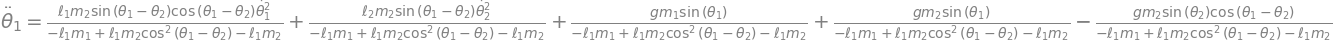

In [130]:
sp.Eq(theta_1_ddot, solution1)

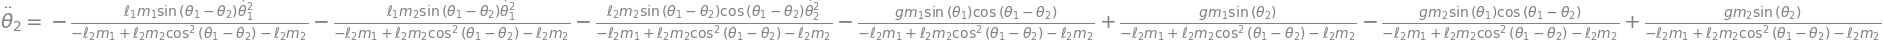

In [131]:
sp.Eq(theta_2_ddot, solution2)

We must decompose the second order ODEs into a system of first order ODEs. Any second order ODE can be split into 2 first order ODEs by defining a new variable as the derivate of the original variable:

$$
\dot \theta_1 = \omega_1 ~~~~~~~~~~~~~~~~~~~~~~~ \dot \theta_2 = \omega_2
$$
$$
\ddot \theta_1 = \dot \omega_1 ~~~~~~~~~~~~~~~~~~~~~~~ \ddot \theta_2 = \dot \omega_2
$$

Now we have 4 first order ODEs:
* $\dot \theta_1 = \omega_1$
* $\dot \theta_2 = \omega_2$
* $\dot \omega_1 = ...$
* $\dot \omega_2 = ...$

Now we convert the **symboilc** equations into **numeric** functions with the sympy function `lamdify()`:

In [17]:
omega_1_dot_f = sp.lambdify((t, g, ell_1, ell_2, m_1, m_2, theta_1, theta_2, theta_1_dot, theta_2_dot), solution1)
omega_2_dot_f = sp.lambdify((t, g, ell_1, ell_2, m_1, m_2, theta_1, theta_2, theta_1_dot, theta_2_dot), solution2)
theta_1_dot_f = sp.lambdify(theta_1_dot, theta_1_dot)
theta_2_dot_f = sp.lambdify(theta_2_dot, theta_2_dot)

We must define $\vec S = [\theta_1, \theta_2, \omega_1, \omega_2]$ which is a vector that's the system of ODEs. To use a differential equation solver, we must define a function that takes $\vec S$ and $t$ as arguments and returns the derivative of $\vec S$ with respect to $t$, $\dfrac{d \vec S}{dt}$ or $\dot{\vec S}$.

In [18]:
def S_dot(t, S, g, ell_1, ell_2, m_1, m_2):
    theta_1, theta_2, omega_1, omega_2 = S
    return [
        theta_1_dot_f(omega_1),
        theta_2_dot_f(omega_2),
        omega_1_dot_f(t, g, ell_1, ell_2, m_1, m_2, theta_1, theta_2, omega_1, omega_2),
        omega_2_dot_f(t, g, ell_1, ell_2, m_1, m_2, theta_1, theta_2, omega_1, omega_2)
    ]

In [33]:
print(sp.print_latex(solution2))

- \frac{\ell_{1} m_{1} \sin{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{1}{\left(t \right)}\right)^{2}}{- \ell_{2} m_{1} + \ell_{2} m_{2} \cos^{2}{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} - \ell_{2} m_{2}} - \frac{\ell_{1} m_{2} \sin{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{1}{\left(t \right)}\right)^{2}}{- \ell_{2} m_{1} + \ell_{2} m_{2} \cos^{2}{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} - \ell_{2} m_{2}} - \frac{\ell_{2} m_{2} \sin{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} \cos{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{2}{\left(t \right)}\right)^{2}}{- \ell_{2} m_{1} + \ell_{2} m_{2} \cos^{2}{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} - \ell_{2} m_{2}} - \frac{g m_{1} \sin{\left(\theta_{1}

$$
\dot{\vec S} =
\left[\begin{matrix}\dot{\theta}_{1}\\
\dot{\theta}_{2}\\\dot{\omega}_{1}\\
\dot{\omega}_{2}\end{matrix}\right]
=
\left[\begin{matrix}
{\omega}_{1}\\
\newline ~ \newline ~ \newline

{\omega}_{2}\\

\newline ~ \newline ~ \newline

\frac{\ell_{1} m_{2} \sin{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} \cos{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{1}{\left(t \right)}\right)^{2}}{- \ell_{1} m_{1} + \ell_{1} m_{2} \cos^{2}{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} - \ell_{1} m_{2}} + \frac{\ell_{2} m_{2} \sin{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{2}{\left(t \right)}\right)^{2}}{- \ell_{1} m_{1} + \ell_{1} m_{2} \cos^{2}{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} - \ell_{1} m_{2}} +
\newline ~ \newline
\frac{g m_{1} \sin{\left(\theta_{1}{\left(t \right)} \right)}}{- \ell_{1} m_{1} + \ell_{1} m_{2} \cos^{2}{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} - \ell_{1} m_{2}} +
\newline ~ \newline
\frac{g m_{2} \sin{\left(\theta_{1}{\left(t \right)} \right)}}{- \ell_{1} m_{1} + \ell_{1} m_{2} \cos^{2}{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} - \ell_{1} m_{2}} - \frac{g m_{2} \sin{\left(\theta_{2}{\left(t \right)} \right)} \cos{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)}}{- \ell_{1} m_{1} + \ell_{1} m_{2} \cos^{2}{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} - \ell_{1} m_{2}}\\

\newline ~ \newline ~ \newline

- \frac{\ell_{1} m_{1} \sin{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{1}{\left(t \right)}\right)^{2}}{- \ell_{2} m_{1} + \ell_{2} m_{2} \cos^{2}{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} - \ell_{2} m_{2}} - \frac{\ell_{1} m_{2} \sin{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{1}{\left(t \right)}\right)^{2}}{- \ell_{2} m_{1} + \ell_{2} m_{2} \cos^{2}{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} - \ell_{2} m_{2}} - 
\newline ~ \newline
\frac{\ell_{2} m_{2} \sin{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} \cos{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} \left(\frac{d}{d t} \theta_{2}{\left(t \right)}\right)^{2}}{- \ell_{2} m_{1} + \ell_{2} m_{2} \cos^{2}{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} - \ell_{2} m_{2}} - 
\newline ~ \newline
\frac{g m_{1} \sin{\left(\theta_{1}{\left(t \right)} \right)} \cos{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)}}{- \ell_{2} m_{1} + \ell_{2} m_{2} \cos^{2}{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} - \ell_{2} m_{2}} + \frac{g m_{1} \sin{\left(\theta_{2}{\left(t \right)} \right)}}{- \ell_{2} m_{1} + \ell_{2} m_{2} \cos^{2}{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} - \ell_{2} m_{2}} - 
\newline ~ \newline
\frac{g m_{2} \sin{\left(\theta_{1}{\left(t \right)} \right)} \cos{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)}}{- \ell_{2} m_{1} + \ell_{2} m_{2} \cos^{2}{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} - \ell_{2} m_{2}} + \frac{g m_{2} \sin{\left(\theta_{2}{\left(t \right)} \right)}}{- \ell_{2} m_{1} + \ell_{2} m_{2} \cos^{2}{\left(\theta_{1}{\left(t \right)} - \theta_{2}{\left(t \right)} \right)} - \ell_{2} m_{2}}
\end{matrix}\right]
$$


Now we can solve the system of ODEs with the `solve_ivp()` function from the `scipy.integrate` module. This function takes in a function that returns the derivative of $\vec S$ with respect to $t$, $\dot{\vec S}$, and the initial conditions $\vec S_0$. It also takes in the time span and an array of times to evaluate the solution at. What we get returned is an object that contains the solution to the ODEs at the times we specified.

In [19]:
param_g = 9.81 # ms^-2

param_m_1 = 2 # kg
param_m_2 = 1 # kg

param_ell_1 = 2 # m
param_ell_2 = 6 # m

pendulum_params = (param_g, param_ell_1, param_ell_2, param_m_1, param_m_2)

# paramial conditions theta_1_0 = theta_1_0 = 30°, theta_2 = 30°, v_1 = v_2 = 0 ms^-1
theta_1_0 = np.deg2rad(75)
theta_2_0 = np.deg2rad(50)
omega_1_0 = np.deg2rad(-120)
omega_2_0 = np.deg2rad(20)
S_0 = [theta_1_0, theta_2_0, omega_1_0, omega_2_0]

t_0 = 0
t_f = 40
time_frame = [t_0, t_f]
t_eval = np.linspace(t_0, t_f, t_f * 25) # @ 25 fps

sol = solve_ivp(
    S_dot,
    time_frame,
    S_0,
    t_eval=t_eval,
    args=pendulum_params,
)

We can assign the arrays from the solution object to the variables $\Theta_1$, $\Theta_2$, $\Omega_1$, and $\Omega_2$ (capital letters to distinguish them from the symbolic variables). We will also assign the time array to the variable time (lowercase t represents the symbolic variable and uppercase T represents the kinetic energy so we can't use those).

In [20]:
Theta_1, Theta_2, Omega_1, Omega_2 = sol.y
time = sol.t

We can convert $\Theta_1$, $\Theta_2$, $\Omega_1$, and $\Omega_2$, which are in radians, to degrees with the `np.rad2deg()` function from the `numpy` module.

In [21]:
Theta_1_deg, Theta_2_deg, Omega_1_deg, Omega_2_deg = np.rad2deg([Theta_1, Theta_2, Omega_1, Omega_2])

Now we can save the data to a csv file with the `np.savetxt()` function from the `numpy` module. We use `np.transpose()` to make the data easier to read by having the columns represent the variables and the rows represent the time intervals.

In [22]:
np.savetxt(
    "double_pendulum.csv",
    np.transpose([time, Theta_1_deg, Theta_2_deg, Omega_1_deg, Omega_2_deg]),
    delimiter=",", 
)

The block below changes some of the default settings for the pyplot module. Essentially, we are inverting the colour scheme to give it a dark background and light text.

In [23]:
plt.rcParams["axes.facecolor"] = "black"
plt.rcParams["axes.labelcolor"] = "white"
plt.rcParams["axes.titlecolor"] = "white"
plt.rcParams["figure.facecolor"] = "black"
plt.rcParams["legend.labelcolor"] = "white"
plt.rcParams["xtick.labelcolor"] = "white"
plt.rcParams["ytick.labelcolor"] = "white"
plt.rcParams["grid.color"] = "#707070"

Now Let's plot $\Theta_1$, $\Theta_2$, $\Omega_1$, and $\Omega_2$ vs time. We can use the `plt.plot()` function from the `matplotlib.pyplot` module. We will plot these as different subplots in a 2x2 grid with the `plt.subplot()` function.

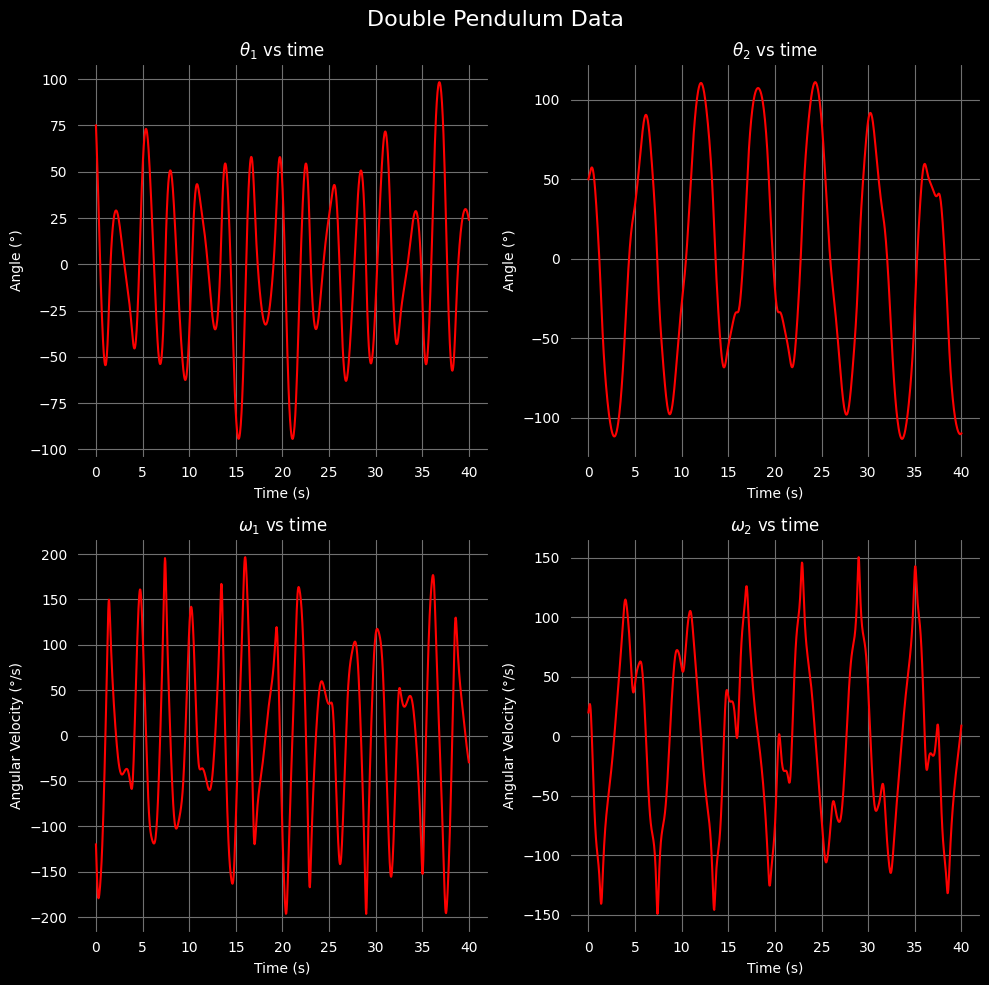

In [24]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, figure=fig)

# Theta_1
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(time, Theta_1_deg, color="#FF0000")
ax1.set_title(r"$\theta_1$ vs time")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Angle (°)")
ax1.grid()

# Theta_2
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(time, Theta_2_deg, color="#FF0000")
ax2.set_title(r"$\theta_2$ vs time")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Angle (°)")
ax2.grid()

# Omega_1
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(time, Omega_1_deg, color="#FF0000")
ax3.set_title(r"$\omega_1$ vs time")
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Angular Velocity (°/s)")
ax3.grid()

# Omega_2
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(time, Omega_2_deg, color="#FF0000")
ax4.set_title(r"$\omega_2$ vs time")
ax4.set_xlabel("Time (s)")
ax4.set_ylabel("Angular Velocity (°/s)")
ax4.grid()

# Title to go over all subplots
plt.suptitle("Double Pendulum Data", color="white", fontsize=16)

plt.tight_layout()  
plt.savefig("Figures/double_pendulum_data.png", dpi=300)
plt.show()

C:\Users\Owner\AppData\Local\Temp\ipykernel_13944\515897277.py:59: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point1.set_data([time[i], Theta_1_deg[i]])
C:\Users\Owner\AppData\Local\Temp\ipykernel_13944\515897277.py:61: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point2.set_data([time[i], Theta_2_deg[i]])
C:\Users\Owner\AppData\Local\Temp\ipykernel_13944\515897277.py:63: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point3.set_data([time[i], Omega_1_deg[i]])
C:\Users\Owner\AppData\Local\Temp\ipykernel_13944\515897277.py:65: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point4.set_data([time[i], Omega_2_deg[i]])


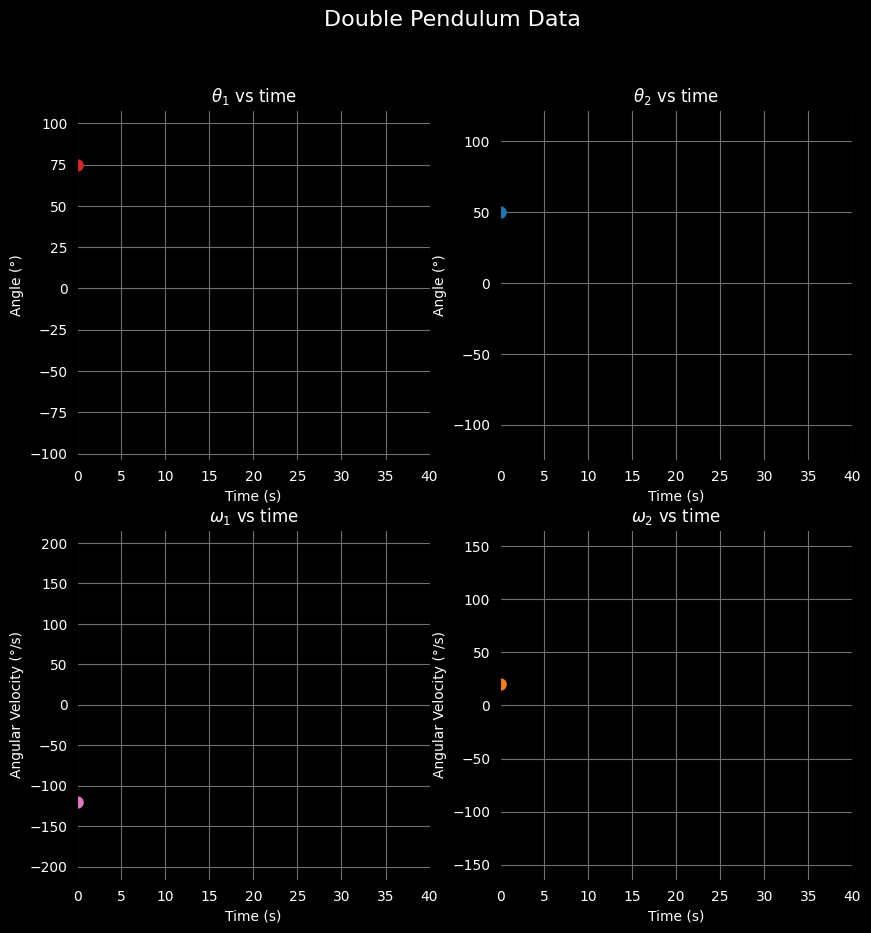

In [334]:
fig, ax = plt.subplots(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, figure=fig)
plt.clf()

# theta_1 vs time
ax1 = fig.add_subplot(gs[0, 0])
line1, = ax1.plot([], [], lw=1, markersize=8, color="tab:red", linestyle="-")
point1, = ax1.plot([], [], lw=1, markersize=8, color="tab:red", marker="o", linestyle="--")

ax1.set_title(r"$\theta_1$ vs time")
ax1.set_xlim(t_0, t_f)
ax1.set_ylim(1.1 * np.min(Theta_1_deg), 1.1 * np.max(Theta_1_deg))
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Angle (°)")
ax1.grid()

# theta_2 vs time
ax2 = fig.add_subplot(gs[0, 1])
line2, = ax2.plot([], [], lw=1, markersize=8, color="tab:blue", linestyle="-")
point2, = ax2.plot([], [], lw=1, markersize=8, color="tab:blue", marker="o", linestyle="--")

ax2.set_title(r"$\theta_2$ vs time")
ax2.set_xlim(t_0, t_f)
ax2.set_ylim(1.1 * np.min(Theta_2_deg), 1.1 * np.max(Theta_2_deg))
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Angle (°)")
ax2.grid()

# omega_1 vs time
ax3 = fig.add_subplot(gs[1, 0])
line3, = ax3.plot([], [], lw=1, markersize=8, color="tab:pink", linestyle="-")
point3, = ax3.plot([], [], lw=1, markersize=8, color="tab:pink", marker="o", linestyle="--")

ax3.set_title(r"$\omega_1$ vs time")
ax3.set_xlim(t_0, t_f)
ax3.set_ylim(1.1 * np.min(Omega_1_deg), 1.1 * np.max(Omega_1_deg))
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Angular Velocity (°/s)")
ax3.grid()

# omega_2 vs time
ax4 = fig.add_subplot(gs[1, 1])
line4, = ax4.plot([], [], lw=1, markersize=8, color="tab:orange", linestyle="-")
point4, = ax4.plot([], [], lw=1, markersize=8, color="tab:orange", marker="o", linestyle="--")

ax4.set_title(r"$\omega_2$ vs time")
ax4.set_xlim(t_0, t_f)
ax4.set_ylim(1.1 * np.min(Omega_2_deg), 1.1 * np.max(Omega_2_deg))
ax4.set_xlabel("Time (s)")
ax4.set_ylabel("Angular Velocity (°/s)")
ax4.grid()


# Title to go over all subplots
plt.suptitle("Double Pendulum Data", color="white", fontsize=16)

def animate(i):
    line1.set_data(time[:i], Theta_1_deg[:i])
    point1.set_data(time[i], Theta_1_deg[i])
    line2.set_data(time[:i], Theta_2_deg[:i])
    point2.set_data(time[i], Theta_2_deg[i])
    line3.set_data(time[:i], Omega_1_deg[:i])
    point3.set_data(time[i], Omega_1_deg[i])
    line4.set_data(time[:i], Omega_2_deg[:i])
    point4.set_data(time[i], Omega_2_deg[i])


ani = animation.FuncAnimation(fig, animate, frames=len(time), interval=50)
ani.save("Animations/double_pendulum_data.gif", writer="pillow", fps=25)

We must define a function that takes $\Theta_1$ and $\Theta_2$, which are are arrays, and returns the x and y coordinates of the two masses. This will be an array representing the coordinates at each time interval. We can use the equations for the x and y coordinates of the masses that we derived earlier.

In [26]:
xm1_f = sp.lambdify((ell_1, theta_1), xm1)
ym1_f = sp.lambdify((ell_1, theta_1), ym1)
xm2_f = sp.lambdify((ell_1, ell_2, theta_1, theta_2), xm2)
ym2_f = sp.lambdify((ell_1, ell_2, theta_1, theta_2), ym2)

In [27]:
def get_coordinates(time, Theta_1, Theta_2, param_ell_1, param_ell_2):
    return [
        xm1_f(param_ell_1, Theta_1),
        ym1_f(param_ell_1, Theta_1),
        xm2_f(param_ell_1, param_ell_2, Theta_1, Theta_2),
        ym2_f(param_ell_1, param_ell_2, Theta_1, Theta_2)
    ]

X1, Y1, X2, Y2 = get_coordinates(time, Theta_1, Theta_2, param_ell_1, param_ell_2)

Now we have the arrays $X1$, $Y1$, $X2$, and $Y2$ which represent the x and y coordinates of the two masses. We can now create an animate function to animate our double pendulum. Our animate function will take in the time array and the arrays $X1$, $Y1$, $X2$, and $Y2$. It sets the data of `ln1` which is a plot that shows the pendulum. `ln1` is definied with `plt.plot`, with the first two positional arguments being empty lists because it starts with no data. The other arguments give stylistic properties to the plot.

Our variable ani is an animation object that is created with the `animation.FuncAnimation()` function. This function takes in the figure, the animate function, and a number of frames to animate. We can also specify the interval between frames in milliseconds. The way the function works is that it evaluates the animate function at each frame and updates the figure with the new data. Each frame of the figure is a snapshot of the pendulum at a certain time, which is put together to create the animation. Take `i=0`, the first frame. `animate(0)` sets the data of ln1. The first list would be [0, X1[0], [X2[0]] and the second list would be `[0, Y1[0], [Y2[0]]`. `plt.plot()` takes this to create a line with three points, being the elements of the lists paired together. The first point is the origin, `(0, 0)`, the second point is the first mass, `(X1[0], Y1[0])`, and the third point is the second mass, `(X2[0], Y2[0])`. The animate function is then evaluated at the next frame, `i=1`, and the data of `ln1` is updated. This process is repeated until the last frame.

The way the trails are created for the masses is by creating two new lines, each one being a trail. The animate function then sets the data of them, being all of the values of the coordinate arrays up to the current frame. We can do this with the string slice operator, getting every frame from the first to the $i$ th frame. ln2 is the trail for the first mass, with coordinates `(X1, Y1)`, and ln3 is the trail for the second mass, with coordinates `(X2, Y2)`.

The save function saves the animation to a file. The first argument is the name of the file, the second argument is the writer, and the third argument is the number of frames per second. We have chosen 25 frames per second because that is the amount of time intervals per second used by the `solve_ivp()` function to solve our system of ODEs.

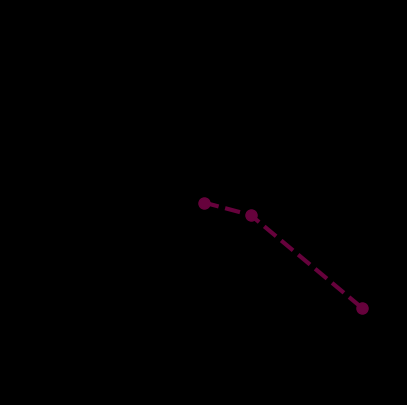

In [315]:
def animate(i):
    ln1.set_data([0, X1[i], X2[i]], [0, Y1[i], Y2[i]])
    # Trailing line for mass 1
    ln2.set_data(X1[:i], Y1[:i])
    
    # # Trailing line for mass 2
    ln3.set_data(X2[:i], Y2[:i])
    

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.set_facecolor("k") # enable this to hide background
ax.get_xaxis().set_ticks([]) # enable this to hide x axis ticks
ax.get_yaxis().set_ticks([]) # enable this to hide y axis ticks

# plot the line
ln1, = plt.plot([], [], lw=3, markersize=8, color="#66023c", marker="o", linestyle="--")

# set the axes limits
ax.set_xlim(-(param_ell_1 + param_ell_2), (param_ell_1 + param_ell_2))
ax.set_ylim(-(param_ell_1 + param_ell_2), (param_ell_1 + param_ell_2))

# Trailing line
ln2, = plt.plot([], [], lw=1, markersize=8, color="red", linestyle="-")
ln3, = plt.plot([], [], lw=1, markersize=8, color="blue", linestyle="-")

# create and save the animation
ani = animation.FuncAnimation(fig, animate, frames=len(X1), interval=50)
ani.save("Animations/double_pendulum.gif", writer="pillow", fps=25)

Let's plot the kinetic, potential, and total energy of the system vs time. We can use the `plt.plot()` function from the `matplotlib.pyplot` module. We will plot these on the same grid to better analyse the relationships between them. Note that the unit for energy here is Joules (J). We can check this by looking at the kinetic energy equation, $T_1 = \frac{1}{2}m_1v_1^2 \rightarrow kg \cdot m^2 \cdot s^{-2} = J$.

In [269]:
# Kinetic Energy
kinetic_f = sp.lambdify((m_1, m_2, ell_1, ell_2, theta_1, theta_2, theta_1_dot, theta_2_dot),T)

kinetic_array = kinetic_f(param_m_1, param_m_2, param_ell_1, param_ell_2, Theta_1, Theta_2, Omega_1, Omega_2)

# Potential Energy
potential_f = sp.lambdify((m_1, m_2, g, ell_1, ell_2, theta_1, theta_2), V)

potential_array = potential_f(param_m_1, param_m_2, param_g, param_ell_1, param_ell_2, Theta_1, Theta_2)

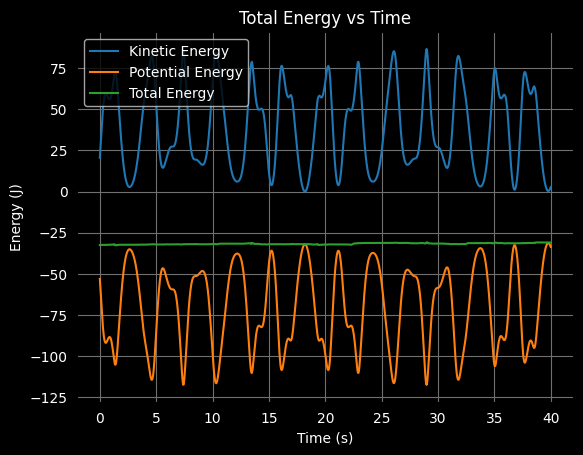

In [302]:
plt.plot(time, kinetic_array)
plt.plot(time, potential_array)

plt.plot(time, kinetic_array + potential_array)

plt.title("Total Energy vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.legend(["Kinetic Energy", "Potential Energy", "Total Energy"])
plt.grid()

plt.savefig("Figures/double_pendulum_energy.png", dpi=300)
plt.show()

It looks as if the total energy is not conserved. This is because the numerical solution is not exact. The numerical solution is an approximation of the exact solution. The numerical solution is only as accurate as the time step used by the `solve_ivp()` function. The smaller the time step, the more accurate the solution is. However, the smaller the time step, the longer it takes to solve the system of ODEs. The `solve_ivp()` function uses a time step that is small enough to give a reasonably accurate solution while also being fast enough to solve the system of ODEs in a reasonable amount of time. This is why the total energy is not conserved.

For chaotic systems, the inaccuracy increases with time which can be seen with the graphed data. There will be a point where the energy is not even close to being conserved, showing the difficulty of numerically solving chaotic systems.

We can also plot the angular momentum of the system vs time. We can use the `plt.plot()` function from the `matplotlib.pyplot` module. We will plot this on the same grid to better analyse the relationships between them. Note that the unit for angular momentum here is $kg \cdot m^2 \cdot s^{-1}$. This is shown by the equation for angular momentum, $L = m \cdot v \cdot r \rightarrow kg \cdot m^2 \cdot s^{-1}$. Note that it can also be written as the product of the moment of inertia and the angular velocity, $L = I \cdot \omega \rightarrow kg \cdot m^2 \cdot s^{-1}$. Angular velocity is in radians per second, but radians are unitless so its just $s^{-1}$. We can write angular momentum as Joules times seconds, $m \cdot v \cdot r = J \cdot s \rightarrow kg \cdot m^2 \cdot s^{-2} \cdot s = kg \cdot m^2 \cdot s^{-1}$.

To calculate the angular momentum, we need the angular velocity of each mass. We can use the equations for angular velocity that we derived earlier. After calculating the angular velocity, we can calculate the angular momentum with the equation $L = I \cdot \omega$. The moment of inertia of a point mass is $I = m \cdot r^2$. $r$ is the distance from the origin to the mass. We can use the equations for the x and y coordinates of the masses that we derived earlier to calculate $r$. We can then calculate the angular momentum of each mass and add them together to get the total angular momentum of the system.

In [271]:
radius_1 = sp.sqrt(xm1**2 + ym1**2)
radius_2 = sp.sqrt(xm2**2 + ym2**2)

inertia_1 = m_1 * radius_1**2
inertia_2 = m_2 * radius_2**2

inertia_1_f = sp.lambdify((m_1, ell_1, theta_1), inertia_1)
inertia_2_f = sp.lambdify((m_2, ell_1, ell_2, theta_1, theta_2), inertia_2)

inertia_1_array = inertia_1_f(param_m_1, param_ell_1, Theta_1)
inertia_2_array = inertia_2_f(param_m_2, param_ell_1, param_ell_2, Theta_1, Theta_2)

angular_momentum_1 = inertia_1_array * Omega_1
angular_momentum_2 = inertia_2_array * Omega_2

total_angular_momentum = angular_momentum_1 + angular_momentum_2

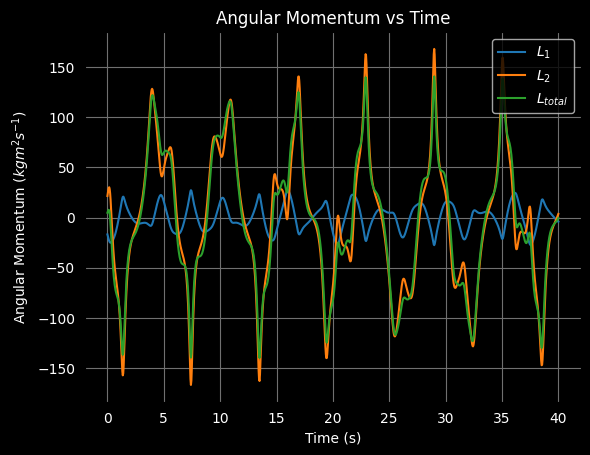

In [301]:
plt.plot(time, angular_momentum_1)
plt.plot(time, angular_momentum_2)
plt.plot(time, total_angular_momentum)

plt.title("Angular Momentum vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Angular Momentum ($kg m^2 s^{-1}$)")
plt.legend([r"$L_1$", r"$L_2$", r"$L_{total}$"])
plt.grid()

plt.savefig("Figures/double_pendulum_angular_momentum.png", dpi=300)
plt.show()

We can notice that the moment of inertia of the first mass is constant, but the moment of inertia of the second mass is not. This is because the moment of inertia of the second mass depends on the angle of the first mass. The moment of inertia of the second mass is $I_2 = m_2 \cdot r_2^2 = m_2 \cdot (r_1^2 + r_2^2 - 2 \cdot r_1 \cdot r_2 \cdot \cos(\theta_1 - \theta_2))$. The moment of inertia of the second mass depends on the angle of the first mass, $\theta_1$, which is not constant. This is why the moment of inertia of the second mass is not constant.

We can also plot the phase space of the system. This is a graph that shows every possible state of the system. The x-axis will be the two angles ($\theta1$, $\theta2$), and the y-axis will be the two angular velocities ($\omega1$, $\omega2$). We can use the `plt.plot()` function from the `matplotlib.pyplot` module. We will plot this on the same grid to better analyse the relationships between them. Note that the unit for the angles is radians (rad) and the unit for the angular velocities is radians per second ($s^{-1}$).

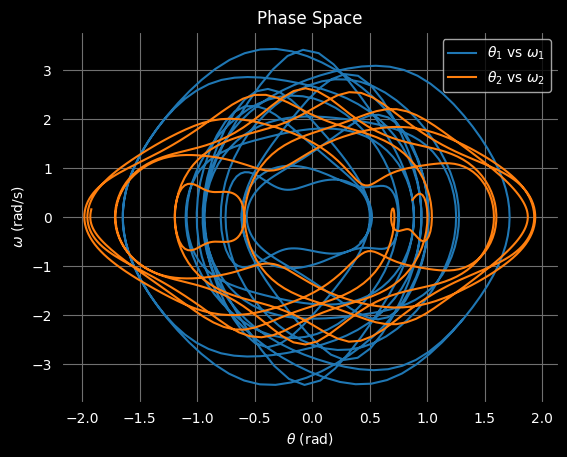

In [47]:
# Phase Space
plt.plot(Theta_1, Omega_1)
plt.plot(Theta_2, Omega_2)


plt.title("Phase Space")
plt.xlabel(r"$\theta$ (rad)")
plt.ylabel(r"$\omega$ (rad/s)")
plt.legend([r"$\theta_1$ vs $\omega_1$", r"$\theta_2$ vs $\omega_2$"])
plt.grid()

plt.savefig("Figures/double_pendulum_phase_space.png", dpi=300)
plt.show()


C:\Users\Owner\AppData\Local\Temp\ipykernel_13920\3180057393.py:20: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  phase_point_1.set_data(Theta_1[i], Omega_1[i])
C:\Users\Owner\AppData\Local\Temp\ipykernel_13920\3180057393.py:22: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  phase_point_2.set_data(Theta_2[i], Omega_2[i])


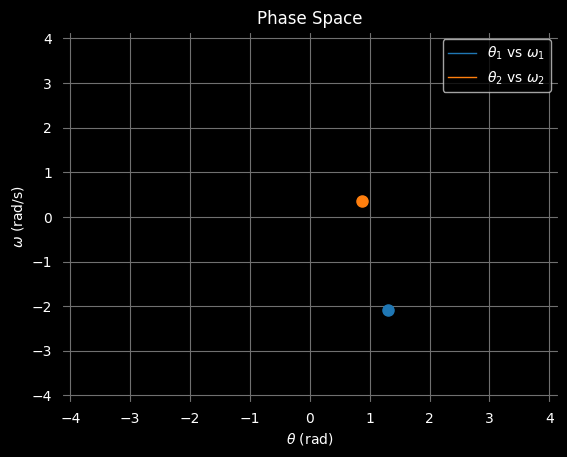

In [29]:
fig, ax = plt.subplots()

phase_curve_1, = ax.plot([], [], lw=1, markersize=8, color="tab:blue", linestyle="-")
phase_curve_2, = ax.plot([], [], lw=1, markersize=8, color="tab:orange", linestyle="-")

phase_point_1, = ax.plot([], [], lw=1, markersize=8, color="tab:blue", marker="o", linestyle="--")
phase_point_2, = ax.plot([], [], lw=1, markersize=8, color="tab:orange", marker="o", linestyle="--")

ax.set_xlim(-np.pi-1, np.pi+1)
ax.set_ylim(-np.pi-1, np.pi+1)

ax.set_title("Phase Space")
ax.set_xlabel(r"$\theta$ (rad)")
ax.set_ylabel(r"$\omega$ (rad/s)")
ax.legend([r"$\theta_1$ vs $\omega_1$", r"$\theta_2$ vs $\omega_2$"])
ax.grid()

def animate(i):
    phase_curve_1.set_data(Theta_1[:i], Omega_1[:i])
    phase_point_1.set_data(Theta_1[i], Omega_1[i])
    phase_curve_2.set_data(Theta_2[:i], Omega_2[:i])
    phase_point_2.set_data(Theta_2[i], Omega_2[i])
    
ani = animation.FuncAnimation(fig, animate, frames=len(X1), interval=50)
ani.save("Animations/double_pendulum_phase_space.gif", writer="pillow", fps=25)